# Introduction

In [16]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.switch_backend('Agg')
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Dataset

In [17]:
# Load dataset
path = r'..\Datasets\Nobel_Prize.csv'
df = pd.read_csv(path)
print("Shape:", df.shape)
df.head()

Shape: (995, 33)


,award_year,date_awarded,prize_amount,prize_amount_adjusted,laureate_id,known_name,full_name,sex,portion,sort_order,...,affiliation_city,affiliation_country,affiliation_latitude,affiliation_longitude,wikipedia_url,is_shared,winners_per_year,winners_per_category,is_repeat_winner,country_winner_rank
0,1901,11/12/1901,150782,10833458,160.0,Jacobus H. van 't Hoff,Jacobus Henricus van 't Hoff,male,1.0,1.0,...,Berlin,Germany,52.522265,13.406852,https://en.wikipedia.org/wiki/Jacobus_Henricus...,0,6,200,0,1.0
1,1901,11/14/1901,150782,10833458,569.0,Sully Prudhomme,Sully Prudhomme,male,1.0,1.0,...,NaN,NaN,NaN,NaN,https://en.wikipedia.org/wiki/Sully_Prudhomme,0,6,122,0,1.0
2,1901,12/10/1901,150782,10833458,462.0,Henry Dunant,Jean Henry Dunant,male,0.5,1.0,...,Geneva,Switzerland,NaN,NaN,https://en.wikipedia.org/wiki/Henry_Dunant,1,6,112,0,1.0
3,1901,12/10/1901,150782,10833458,463.0,Frédéric Passy,Frédéric Passy,male,0.5,2.0,...,NaN,NaN,NaN,NaN,https://en.wikipedia.org/wiki/Frédéric_Passy,1,6,112,0,2.0
4,1901,11/12/1901,150782,10833458,1.0,Wilhelm Conrad Röntgen,Wilhelm Conrad Röntgen,male,1.0,1.0,...,Munich,Germany,48.134703,11.581995,https://en.wikipedia.org/wiki/Wilhelm_Röntgen,0,6,230,0,1.0


# Data cleaning and preprocessing

In [18]:
# Converting to datetime and computing derived features
df['date_awarded'] = pd.to_datetime(df['date_awarded'], errors='coerce')
df['birth_date'] = pd.to_datetime(df['birth_date'], errors='coerce')
df['age_at_award'] = (df['date_awarded'] - df['birth_date']).dt.days / 365.25
df['decade'] = (df['award_year'] // 10) * 10

# Overview

In [30]:
overview = {
    "Total Records": len(df),
    "Unique Laureates": df['full_name'].nunique(),
    "Male Laureates": df[df['sex'].str.lower() == 'male'].shape[0],
    "Female Laureates": df[df['sex'].str.lower() == 'female'].shape[0],
    "Earliest Year": df['award_year'].min(),
    "Most Recent Year": df['award_year'].max(),
    "Number of Categories": df['category'].nunique(),
    "Most Frequent Country": df['birth_country'].mode()[0] if df['birth_country'].notna().any() else None
}
pd.DataFrame.from_dict(overview, orient='index', columns=['Value'])

,Value
Total Records,995
Unique Laureates,990
Male Laureates,703
Female Laureates,49
Earliest Year,1901
Most Recent Year,2025
Number of Categories,6
Most Frequent Country,USA


# Exploratory Data Analysis

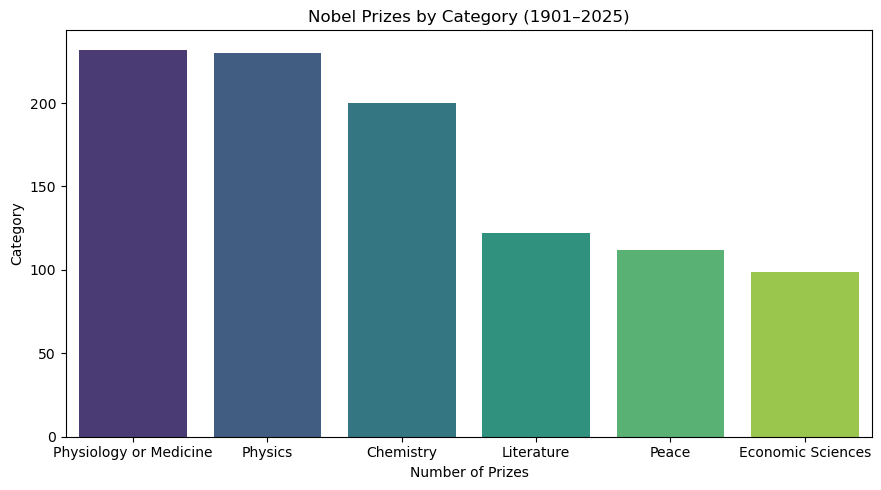

In [20]:
plt.figure(figsize=(9,5))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index, palette='viridis')
plt.title("Nobel Prizes by Category (1901–2025)")
plt.xlabel("Number of Prizes")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

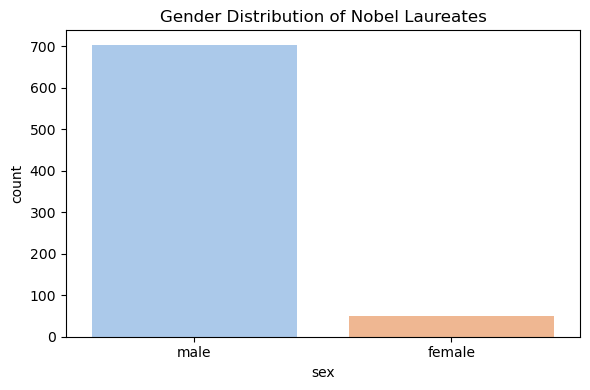

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(x='sex', data=df, palette='pastel')
plt.title("Gender Distribution of Nobel Laureates")
plt.tight_layout()
plt.show()

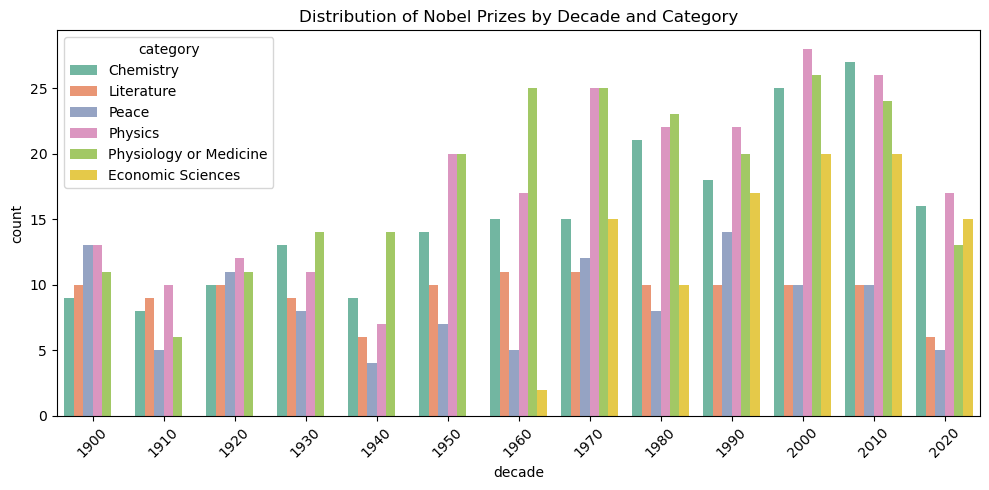

In [22]:
plt.figure(figsize=(10,5))
sns.countplot(x='decade', data=df, hue='category', palette='Set2')
plt.title("Distribution of Nobel Prizes by Decade and Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

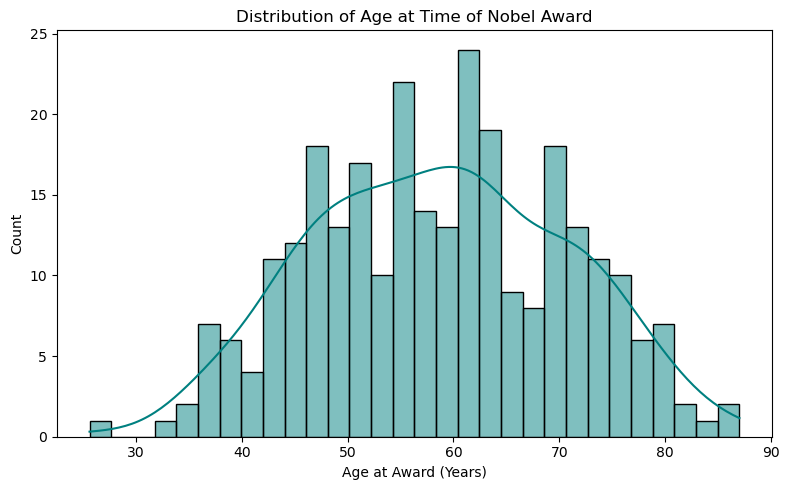

In [23]:
plt.figure(figsize=(8,5))
sns.histplot(df['age_at_award'].dropna(), bins=30, kde=True, color='teal')
plt.title("Distribution of Age at Time of Nobel Award")
plt.xlabel("Age at Award (Years)")
plt.tight_layout()
plt.show()

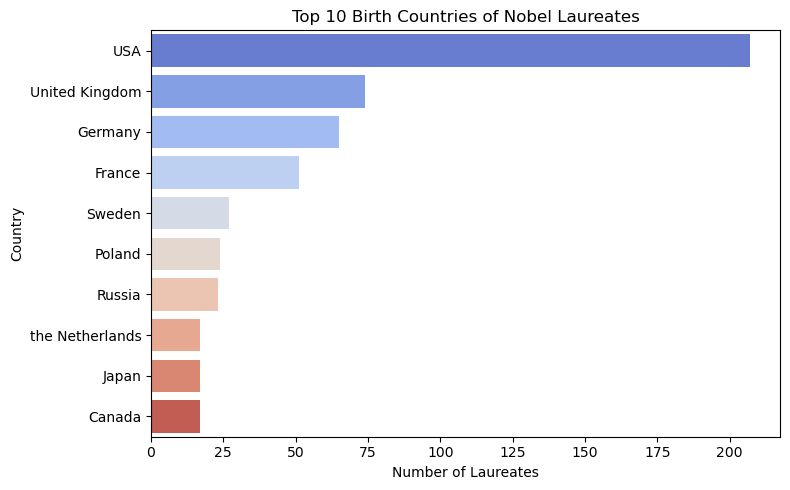

In [24]:
top_countries = df['birth_country'].value_counts().nlargest(10)
plt.figure(figsize=(8,5))
sns.barplot(y=top_countries.index, x=top_countries.values, palette='coolwarm')
plt.title("Top 10 Birth Countries of Nobel Laureates")
plt.xlabel("Number of Laureates")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# Predictive Model

In [25]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Best Parameters: {'clf__C': 2, 'clf__solver': 'lbfgs', 'tfidf__ngram_range': (1, 1)}
Best Cross-Validation Accuracy: 0.9246069182389937

Test Accuracy: 0.9296482412060302

Classification Report:
                         precision    recall  f1-score   support

             Chemistry       0.93      0.95      0.94        40
     Economic Sciences       1.00      0.85      0.92        20
            Literature       0.96      1.00      0.98        24
                 Peace       1.00      0.95      0.98        22
               Physics       0.86      0.91      0.88        46
Physiology or Medicine       0.93      0.91      0.92        47

              accuracy                           0.93       199
             macro avg       0.95      0.93      0.94       199
          weighted avg       0.93      0.93      0.93       199



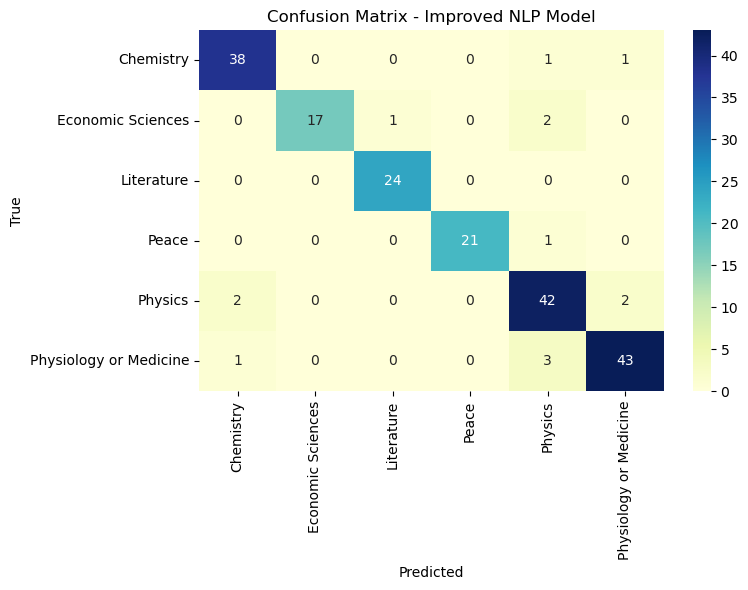

In [26]:
df_nlp = df[['motivation', 'category']].dropna()
X = df_nlp['motivation'].astype(str)
y = df_nlp['category'].astype(str)

# Text cleaning
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    text = re.sub(r"\d+", "", text)
    words = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return " ".join(words)

X_clean = X.apply(clean_text)

# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF + Logistic Regression with GridSearchCV
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=7000)),
    ('clf', LogisticRegression(max_iter=2000))
])
# fit with best hyperparameter tuning XGBoost use RandomizedSearchCV
params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.5, 1, 2],
    'clf__solver': ['liblinear', 'lbfgs']
}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid=params, cv=kf, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

# Evaluating on test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Improved NLP Model")
plt.tight_layout()
plt.show()

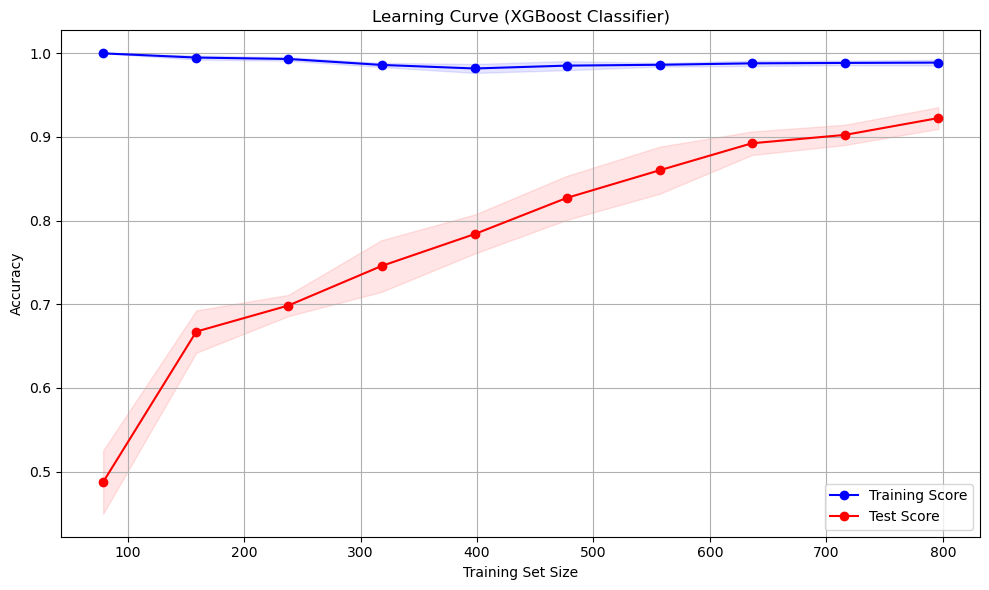

In [27]:
# Check train data and test data with learning curve
train_sizes, train_scores, test_scores = learning_curve(pipeline,
                                                        X_clean,
                                                        y,
                                                        cv=kf,
                                                        scoring='accuracy',
                                                        n_jobs=-1,
                                                        train_sizes=np.linspace(0.1, 1.0, 10))
# Calculate mean and std dev in train and test set
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Test Score')

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.1, color='red')

plt.title('Learning Curve (XGBoost Classifier)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Predicting with single values

In [28]:
example_text = "the discovery of gold was glorious"
print("Predicted category:", best_model.predict([example_text])[0])

Predicted category: Physiology or Medicine
